<a href="https://colab.research.google.com/github/scheung97/EECE5639_ComputerVision/blob/main/p3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
 # Northeastern University
# EECE5639 Computer Vision

# Spenser Cheung & Tim Liming

# Project 3

import cv2 
import numpy as np 
import os
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep
from scipy import ndimage
from scipy import signal

from google.colab.patches import cv2_imshow
from google.colab import drive


In [1]:
!python3 --version
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

Python 3.7.12
     |████████████████████████████████| 25.0 MB 3.1 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6 MB 1.5 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [3]:
# Mount Google Drive in Google Colab

# Public P3 folder link: 
# https://drive.google.com/drive/folders/1y8caBKDzvhXgwu-AbLbjtGWBXKbywQlG?usp=sharing

drive.mount('/content/gdrive', force_remount=True)

P3_path = "/content/gdrive/MyDrive/EECE5639_P3"

Mounted at /content/gdrive


In [12]:
# i. Read in two images.

# cast
p3_files = [filename for filename in sorted(os.listdir(P3_path)) if os.path.isfile(os.path.join(P3_path, filename))]

cast_color = []
cast_gray = []
for i in range(0, len(p3_files)-2): 
    img = cv2.imread(os.path.join(P3_path, p3_files[i]))
    cast_color.append(img)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
    cast_gray.append(gray_img)

cast_color = np.array(cast_color)
print(cast_color.shape)
cast_gray = np.array(cast_gray)
print(cast_gray.shape)

(2, 384, 576, 3)
(2, 384, 576)


In [14]:
# i. Read in two images.

# cones
p3_files = [filename for filename in sorted(os.listdir(P3_path)) if os.path.isfile(os.path.join(P3_path, filename))]

cones_color = []
cones_gray = []
for i in range(2, len(p3_files)): 
    img = cv2.imread(os.path.join(P3_path, p3_files[i]))
    cones_color.append(img)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
    cones_gray.append(gray_img)

cones_color = np.array(cones_color)
print(cones_color.shape)
cones_gray = np.array(cones_gray)
print(cones_gray.shape)

(2, 375, 450, 3)
(2, 375, 450)


Reduced Images:


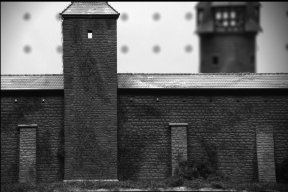

(192, 288)
----------------------------------


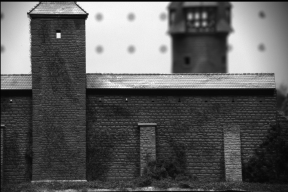

(192, 288)
----------------------------------


In [15]:
# i. Read in two images. (Note: if the images are large, you may want to reduce
# their size to keep running time reasonable! Document in your report the scale
# factor you used.)

use_cast = True
#use_cast = False
if use_cast:
    #img1, img2 = np.random.default_rng().choice(cast_color, 2, replace=False)
    img1 = cast_gray[0]
    img2 = cast_gray[1]
else:
    #img1, img2 = np.random.default_rng().choice(cones_color, 2, replace=False)
    img1 = cones_gray[0]
    img2 = cones_gray[1]

#print('Original Images:')
#cv2_imshow(img1)
#print('--------------------------------------------------------------')
#cv2_imshow(img2)
#print('--------------------------------------------------------------')

scale = 0.5
r_img1 = cv2.resize(img1, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
r_img2 = cv2.resize(img2, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)

print('Reduced Images:')
cv2_imshow(r_img1)
print(r_img1.shape)
print('----------------------------------')
cv2_imshow(r_img2)
print(r_img2.shape)
print('----------------------------------')


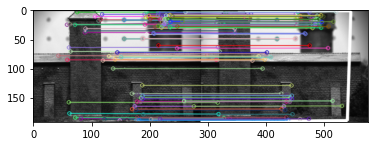

----------------------------------
Homography Matrix:
[[ 1.05974706e+00 -5.37924958e-03 -3.46936742e+01]
 [ 1.33858337e-02  1.04478205e+00 -2.67680904e+00]
 [ 1.45108058e-04  1.06297924e-04  1.00000000e+00]]


In [16]:
# 1. Find interesting features and correspondences between the left and right 
# images. You can use the CORNERS and NCC algorithms that you wrote/used for 
# the second project or SIFT features and descriptors. Display your results in 
# the same way you did for project 2 i.e. by connecting corresponding features 
# with a line. Using lines of different colors for different points makes it 
# easier to visualize the results.

# https://stackoverflow.com/questions/38491959/how-to-apply-ransac-in-python-opencv
# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html

def RANSAC(img1, img2):
    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    img1 = img1[:, :, np.newaxis]
    img2 = img2[:, :, np.newaxis]
    #print(img1.shape)
    #print(img2.shape)

    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches2 = flann.knnMatch(des1, des2, k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches2:
        if m.distance < 0.7*n.distance:
            good.append(m)

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    #print(src_pts)
    #print(dst_pts)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    h,w,d = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,matchesMask = matchesMask, flags = 2)

    plt.imshow(img3, 'gray'),plt.show()

    return M, img3


M, ret = RANSAC(r_img1, r_img2)

print('----------------------------------')
print('Homography Matrix:')
print(M)